In [6]:
import pandas as pd
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score
from scipy.stats import entropy

In [2]:
# Const
RANDOM_STATE = 0
min_rr = 460
max_rr = 963*1.2

print(min_rr, '/', max_rr)

460 / 1155.6


# Полезные методы

In [30]:
def make_XY(df):
    """
    Подготовка признаков для обучения модели
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time'], axis=1)
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X.to_numpy())
    X = scaler.transform(X.to_numpy())

    with open('scaler-mms-pipeline-2.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler-mms-pipeline-2.pkl was saved in output directory')

    return X, y


def plot_RR(rr_ids, data):
    """
    Рисует графики ритмограмм с разметкой аномальных участков
    rr_ids: список идентификаторов ритмограмм
    data: набор данных
    """
    df = data.set_index('time').copy()
    for rr_id in rr_ids:
        fig = plt.figure(figsize=(20,5))
        plt.title(f'R-R №{rr_id}')
        plt.plot(df[df.id == rr_id].x, '-o', zorder=1)
        df_anomaly = df[(df.id == rr_id)&(df.y == 1)].reset_index()
        df_anomaly['time-diff'] = df_anomaly.time.diff()
        split_indexes = df_anomaly[df_anomaly['time-diff'] > 1000].index
        split_indexes = list(split_indexes)
        split_indexes.append(0)
        split_indexes.sort()
        len_spl = len(split_indexes)
        for i in range(len_spl):
            if i == len_spl-1:
                mask = (df_anomaly.index >= split_indexes[i])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                     label='аномальный участок', color='red', zorder=2)
            else:
                mask = (df_anomaly.index >= split_indexes[i])&(df_anomaly.index < split_indexes[i+1])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                         color='red', zorder=2)
        plt.legend()
        plt.xlabel('R-R timeline, ms')
        plt.ylabel('R-R interval')
        plt.show()
        

def entropy1(labels, base=None):
    _, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)


def make_dataset(data):
    """
    Автоматизация подготовки датасета
    """
    df = data.copy()
    ids = df.id.unique()
    for rr_id in ids:
        mask = (df.id==rr_id)
        df.loc[mask, 'entropy'] = df[mask].x.rolling(20).apply(entropy1).fillna(method='bfill')
        df.loc[mask, 'x_diff'] = df[mask].x.diff()
        df.fillna(method='bfill', inplace=True)
        df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
        for i in range(1,5):
            # добавим в признаки 4 следующие точки
            df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
            # и 4 предыдущие точки
            df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
        df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
        df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
        df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
        df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
        df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
        df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
        df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        
    return df

# Подготовка датасета для обучения

In [7]:
df = pd.read_csv('../input/cardiospikecompetition/train.csv')
ids = df.id.unique()
for rr_id in ids:
    mask = (df.id==rr_id)
    df.loc[mask, 'entropy'] = df[mask].x.rolling(20).apply(entropy1).fillna(method='bfill')
    df.loc[mask, 'x_diff'] = df[mask].x.diff()
    df.fillna(method='bfill', inplace=True)
    df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
    for i in range(1,5):
        # добавим в признаки 4 следующие точки
        df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
        # и 4 предыдущие точки
        df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
    df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
    df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
    df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
    df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
    df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
    df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
    df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)

In [9]:
print('TEST')
if (len(df) == len(df.dropna())):
    print('Итог: по размеру датасет соответствует ожидаемому, ' \
          'нужно ещё выбрать контрольный пример для оценки глазами')
    print(':)')
else:
    print('Итог: по размерности не сходится... ' \
          'надо проверить алгоритм добавления признаков')
    print(':(')

TEST
Итог: по размеру датасет соответствует ожидаемому, нужно ещё выбрать контрольный пример для оценки глазами
:)


# Замена выбросов

In [10]:
print(f'количество выбрасов выше {max_rr} =', len(df[df.x > max_rr]))
print(f'количество выбрасов ниже {min_rr} =', len(df[df.x < min_rr]))

количество выбрасов выше 1155.6 = 1015
количество выбрасов ниже 460 = 10220


In [11]:
out_cnt = len(df[(df.x > max_rr)|(df.x < min_rr)].y)
df.loc[df.x > max_rr, 'x'] = pd.NA
df.loc[df.x < min_rr, 'x'] = pd.NA

print('количество NA после мьютирования =', len(df[df.x.isna()]))
if len(df[df.x.isna()]) == out_cnt:
    print('выбросы замьютированы корректно')
else:
    print('мьютирование выбросов прошло некорректно...')

количество NA после мьютирования = 11235
выбросы замьютированы корректно


In [12]:
# индексы, которые были выялены как выбросы
out_ind = df[df.x.isna()].index

In [13]:
# test
df.x.ffill(inplace=True)
# проверка на корректность мьютирования
ind = np.random.randint(len(out_ind))
display(df.loc[[out_ind[ind]-1, out_ind[ind]], 'x'])
if df.loc[out_ind[ind]-1, 'x'] == df.loc[out_ind[ind], 'x']:
    print('\nПроверка прошла успешно! :)')
else:
    print('\nДанные в соседних точках не совпадают... :(')

47497    540
47498    540
Name: x, dtype: int64


Проверка прошла успешно! :)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60487 entries, 0 to 60486
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  60487 non-null  int64  
 1   time                60487 non-null  int64  
 2   x                   60487 non-null  int64  
 3   y                   60487 non-null  int64  
 4   entropy             60487 non-null  float64
 5   x_diff              60487 non-null  float64
 6   x_deviation_median  60487 non-null  float64
 7   x+1                 60487 non-null  float64
 8   x-1                 60487 non-null  float64
 9   x+2                 60487 non-null  float64
 10  x-2                 60487 non-null  float64
 11  x+3                 60487 non-null  float64
 12  x-3                 60487 non-null  float64
 13  x+4                 60487 non-null  float64
 14  x-4                 60487 non-null  float64
 15  x-(x+1)             60487 non-null  float64
 16  x-(x

In [15]:
# сохраним датасет в с текущими признаками, предварительно удалив строки с пропусками
with open('dataset-mms-pipeline-2.pkl', 'wb') as f:
    pickle.dump(df, f)
    
df.to_csv('dataset-mms-pipeline-2.csv')

# Кросс-валидация

In [16]:
# make X and y
X,y = make_XY(df)

scaler-mms-pipeline-2.pkl was saved in output directory


In [17]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)

cv_result = cross_validate(model, X, y, cv=StratifiedKFold(), scoring='f1')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())
print('current best mean test_score = 0.7161425084850291')

test_score: [0.80877356 0.71485306 0.5607853  0.75297061 0.74190564]
mean test_score = 0.7158576328153325
current best mean test_score = 0.7161425084850291


# Обучение модели

In [25]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X,y,verbose=False)

LGBMClassifier(learning_rate=0.01, n_estimators=3860, random_state=0)

In [26]:
with open('model-mms-pipeline-2.pkl', 'wb') as f:
    pickle.dump(model, f)

# Проверка на тестовых данных

In [39]:
test_data = pd.read_csv('../input/cardiospikecompetition/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15034 entries, 0 to 15033
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      15034 non-null  int64
 1   time    15034 non-null  int64
 2   x       15034 non-null  int64
dtypes: int64(3)
memory usage: 352.5 KB


In [40]:
test_data.id.unique()

array([ 81, 168, 243, 135,   9,  11, 157, 212, 166, 154, 227, 165,  37,
       274, 211, 200, 183,  26, 175,  50, 141, 198, 114, 181, 171,  83,
         8, 256, 249, 142, 210, 106, 248, 255,  28, 192,  18, 267, 105,
        95,  94, 269,  56,  98, 184, 176])

In [41]:
len(test_data.id.unique())

46

In [42]:
test_df = make_dataset(test_data)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15034 entries, 0 to 15033
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  15034 non-null  int64  
 1   time                15034 non-null  int64  
 2   x                   15034 non-null  int64  
 3   entropy             15034 non-null  float64
 4   x_diff              15034 non-null  float64
 5   x_deviation_median  15034 non-null  float64
 6   x+1                 15034 non-null  float64
 7   x-1                 15034 non-null  float64
 8   x+2                 15034 non-null  float64
 9   x-2                 15034 non-null  float64
 10  x+3                 15034 non-null  float64
 11  x-3                 15034 non-null  float64
 12  x+4                 15034 non-null  float64
 13  x-4                 15034 non-null  float64
 14  x-(x+1)             15034 non-null  float64
 15  x-(x+2)             15034 non-null  float64
 16  x-(x

In [43]:
with open('scaler-mms-pipeline-2.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
X_test = test_df.drop(['id','time'], axis=1).to_numpy()
X_test = scaler.transform(X_test)

print(X_test.shape)

(15034, 19)


In [44]:
y_pred = model.predict(X_test)

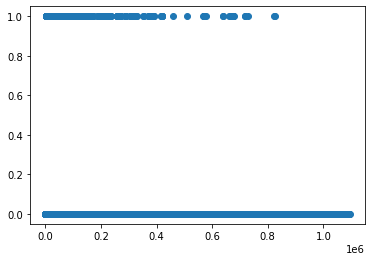

In [45]:
plt.plot(test_df.time, y_pred, 'o');

In [46]:
# submit
submit = test_data.copy()
submit['y'] = y_pred
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15034 entries, 0 to 15033
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      15034 non-null  int64
 1   time    15034 non-null  int64
 2   x       15034 non-null  int64
 3   y       15034 non-null  int64
dtypes: int64(4)
memory usage: 469.9 KB


In [47]:
submit

,id,time,x,y
0,81,0,576,0
1,81,568,568,0
2,81,1140,572,0
3,81,1716,576,0
4,81,2284,568,0
...,...,...,...,...
15029,176,44332,568,1
15030,176,44968,636,1
15031,176,45596,628,0
15032,176,46904,1308,0


In [48]:
submit.to_csv('submit-mms-pipeline-2.csv', index=False)